### Load Library

In [1]:
import os, warnings, sklearn, matplotlib, torch, time, cv2, math, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.layers import Concatenate
from matplotlib import pyplot
import tensorflow.keras as K
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3480128122538116622,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7801405440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9832462470230549480
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:05:00.0, compute capability: 8.6"]

In [2]:
# GPU-initialization
session = None
if (session):
    session.close()
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs: 1


---

### Load Tensor

In [5]:
def load_tensor(dir_path = ["media", "tensor", "link", "portable1", "tensor"]):
    '''
    tensor 가져오는 방식을 csv에서 가져온 번호에서 부터 불러오도록 설정
    output 에 nums는 현재 가져온곳의 한글값을 표현하기 위해서 
    '''
    #dir_path = os.path.join(*dir_path)
    dir_path = '/media/link/portable1/tensor'
    tensor_folders = sorted(os.listdir(dir_path))
    
    h_list = []
    answers = []
    
    # 0 ~ 7 순회
    for tensor_folder in tensor_folders:
        if tensor_folder == "prediction":
            continue
            
        if tensor_folder == "aihub":
            continue
                
        tensors_path = os.path.join(dir_path, tensor_folder)
        tensors = sorted(os.listdir(tensors_path))
        
        
        # 각각의 숫자 순회
        for tensor in tensors:                
            h_list.append(torch.load(os.path.join(tensors_path, tensor, "hand.pt")))
            #h_list.append(torch.load(tensors_path + "\\" + tensor + "\\hp.pt"))
            answers.append(tensor_folder)
            

    return h_list, answers 

In [6]:
h_list, answers = load_tensor() # 훈련데이터
answer_set = list(map(str, sorted(list(set(answers))))) # 정답데이터

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '/media/link/portable1/tensor'

In [5]:
# 시퀀스 최대 길이 설정(각 영상의 최대 프레임 추출 후 이를 적용)
def matchFrame(lst, max_frame):
    for i in range(len(lst)):
        lst[i] = lst[i].view(lst[i].shape[0], -1)
        lst[i] = np.array(F.pad(lst[i], (0, 0, 0, max_frame - lst[i].shape[0]), value=0))
    return np.array(lst)

In [6]:
# 시퀀스 최대 길이 출력
mx = 0
for i in h_list:
       mx = max(mx, i.shape[0])
print(mx)

129


In [7]:
# 시퀀스 최대길이 설정
hand_data = matchFrame(h_list, mx)

In [8]:
# 훈련데이터 Shape
print(hand_data[0].shape)

(129, 126)


In [9]:
x_train, x_val, y_train, y_val = train_test_split(hand_data, answers, test_size=0.075, random_state=42)
#x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [10]:
print(answer_set)

['0', '1', '2', '3', '4', '5', '6', '7', '가끔', '가렵다', '가슴', '감기', '감사합니다', '고열', '골절', '교통사고', '구내염', '귀', '근육통', '눈', '다리', '두드러기', '두통', '등', '따끔거리다', '멍들다', '목', '몸', '몸살', '무릎', '물다', '발목', '부러지다', '붕대', '뼈', '사마귀', '설사', '소화불량', '손', '수술', '심장마비', '쓰러지다', '아프다', '안녕하세요', '어깨', '어지럽다', '얼굴', '열', '의사', '임신', '자주', '찰과상', '코로나', '탈구', '탈모', '토하다', '파상풍', '피', '피부', '허리', '호흡곤란', '화상']


In [11]:
x_train.shape

(5697, 129, 126)

In [12]:
# 정답 데이터 원핫인코딩
encoder = LabelBinarizer()
test = encoder.fit_transform(answer_set)

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
#y_test = encoder.transform(y_test)

In [13]:
# 정답 데이터 shape
print(y_train.shape)

(5697, 62)


### Training

In [14]:
# 바다나우 어텐션
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units' : self.units,
            'W1' : self.W1,
            'W2' : self.W2,
            'V' : self.V,
        })
        return config
        
    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides, padding="same", activation = "relu",use_bias=False),
            keras.layers.BatchNormalization(),
            #self.activation,
            keras.layers.Conv1D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters' : self.filters,
            'activation' : self.activation,
            'main_layers' : self.main_layers,
            'skip_layers' : self.skip_layers,
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [16]:
# Model
dropout = 0.25
num_classes = len(answer_set)
nodesizes = [64, 64]

inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation("relu")(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

conv1 = ResidualUnit(32, 1)(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

conv1 = ResidualUnit(64, 2)(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

lstm = Bidirectional(layers.LSTM(128, return_sequences=True))(conv1)
lstm = layers.Dropout(rate=dropout)(lstm)  

for i in range(0,2):    #number of layers random between 1 an 3
    lstm = Bidirectional(layers.LSTM(nodesizes[i],return_sequences=True))(lstm)
    lstm = layers.Dropout(rate=dropout)(lstm)

#lstm = Bidirectional(layers.LSTM(256))(lstm)
#lstm = layers.Dropout(rate=dropout)(lstm)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (layers.LSTM(64, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의

context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(64, activation="relu")(context_vector)
dropout = layers.Dropout(0.)(dense1)

class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(dense1)

model = keras.models.Model(inputs=inputs, outputs=[class_output])

model.compile(loss={
    'class_output': 'categorical_crossentropy', 
    },
    optimizer='Adamax',
    metrics=['accuracy'])

# Plot the model graph
keras.utils.plot_model(model, 'nn_graph.png', show_shapes=True)

model.summary()

2021-08-22 17:11:38.488866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 17:11:38.489405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 17:11:38.489853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 17:11:38.490334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 17:11:38.490830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 126)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 129, 32)      12128       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 129, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)

In [17]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

In [18]:
epc = 200

history = model.fit(
    x_train, y_train, 
    epochs=epc, 
    batch_size=30, 
    validation_data=(x_val,y_val),
    shuffle=False,
    callbacks=[cb_checkpoint])

2021-08-22 17:11:40.125546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-08-22 17:11:46.441307: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-08-22 17:11:47.671851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


190/190 [==============================] - 12s 19ms/step - loss: 3.2549 - accuracy: 0.1743 - val_loss: 2.9018 - val_accuracy: 0.1688

Epoch 00001: val_loss improved from inf to 2.90182, saving model to ./model/01-2.9018.hdf5
Epoch 2/200
190/190 [==============================] - 2s 10ms/step - loss: 1.6293 - accuracy: 0.5468 - val_loss: 1.5926 - val_accuracy: 0.5065

Epoch 00002: val_loss improved from 2.90182 to 1.59261, saving model to ./model/02-1.5926.hdf5
Epoch 3/200
190/190 [==============================] - 2s 10ms/step - loss: 0.9440 - accuracy: 0.7348 - val_loss: 0.8175 - val_accuracy: 0.7619

Epoch 00003: val_loss improved from 1.59261 to 0.81753, saving model to ./model/03-0.8175.hdf5
Epoch 4/200
190/190 [==============================] - 2s 10ms/step - loss: 0.6070 - accuracy: 0.8336 - val_loss: 0.5396 - val_accuracy: 0.8377

Epoch 00004: val_loss improved from 0.81753 to 0.53964, saving model to ./model/04-0.5396.hdf5
Epoch 5/200
190/190 [==============================] - 

190/190 [==============================] - 2s 10ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.1027 - val_accuracy: 0.9827

Epoch 00040: val_loss did not improve from 0.06204
Epoch 41/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 0.1585 - val_accuracy: 0.9632

Epoch 00041: val_loss did not improve from 0.06204
Epoch 42/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0204 - accuracy: 0.9942 - val_loss: 0.4131 - val_accuracy: 0.9048

Epoch 00042: val_loss did not improve from 0.06204
Epoch 43/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.7471 - val_accuracy: 0.8745

Epoch 00043: val_loss did not improve from 0.06204
Epoch 44/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.2660 - val_accuracy: 0.9502

Epoch 00044: val_loss did not improve from 0.06204
Epoch 45/200
190/190 [======

190/190 [==============================] - 2s 10ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.1091 - val_accuracy: 0.9784

Epoch 00081: val_loss did not improve from 0.03692
Epoch 82/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0360 - accuracy: 0.9916 - val_loss: 0.0930 - val_accuracy: 0.9848

Epoch 00082: val_loss did not improve from 0.03692
Epoch 83/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0404 - val_accuracy: 0.9957

Epoch 00083: val_loss did not improve from 0.03692
Epoch 84/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0778 - val_accuracy: 0.9784

Epoch 00084: val_loss did not improve from 0.03692
Epoch 85/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0384 - val_accuracy: 0.9913

Epoch 00085: val_loss did not improve from 0.03692
Epoch 86/200
190/190 [======

190/190 [==============================] - 2s 10ms/step - loss: 0.0043 - accuracy: 0.9984 - val_loss: 0.0713 - val_accuracy: 0.9827

Epoch 00122: val_loss did not improve from 0.03567
Epoch 123/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.0930 - val_accuracy: 0.9827

Epoch 00123: val_loss did not improve from 0.03567
Epoch 124/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.1018 - val_accuracy: 0.9848

Epoch 00124: val_loss did not improve from 0.03567
Epoch 125/200
190/190 [==============================] - 2s 10ms/step - loss: 6.0121e-04 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9935

Epoch 00125: val_loss did not improve from 0.03567
Epoch 126/200
190/190 [==============================] - 2s 10ms/step - loss: 3.5111e-04 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9957

Epoch 00126: val_loss did not improve from 0.03567
Epoch 127/200
19


Epoch 00162: val_loss did not improve from 0.02551
Epoch 163/200
190/190 [==============================] - 2s 10ms/step - loss: 1.4388e-04 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9978

Epoch 00163: val_loss did not improve from 0.02551
Epoch 164/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0817 - val_accuracy: 0.8463

Epoch 00164: val_loss did not improve from 0.02551
Epoch 165/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0357 - val_accuracy: 0.9957

Epoch 00165: val_loss did not improve from 0.02551
Epoch 166/200
190/190 [==============================] - 2s 9ms/step - loss: 2.7263e-04 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9935

Epoch 00166: val_loss did not improve from 0.02551
Epoch 167/200
190/190 [==============================] - 2s 10ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1549 - val_accuracy: 0.9697

Ep

---

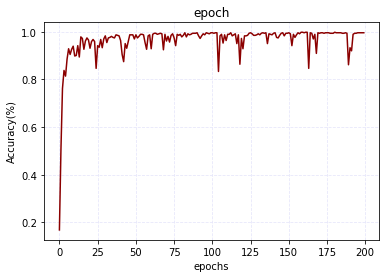

<Figure size 432x288 with 0 Axes>

In [19]:
# 도화지 생성
fig = plt.figure()
# 정확도 그래프 그리기
plt.plot(range(epc), history.history['val_accuracy'], label='Accuracy', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
plt.title('epoch')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()
# 그래프 저장
plt.savefig('sign_launguage_acc.png')

---
### Prediction

In [3]:
# 바다나우 어텐션
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units' : self.units,
            'W1' : self.W1,
            'W2' : self.W2,
            'V' : self.V,
        })
        return config
        
    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides, padding="same", activation = "relu",use_bias=False),
            keras.layers.BatchNormalization(),
            #self.activation,
            keras.layers.Conv1D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters' : self.filters,
            'activation' : self.activation,
            'main_layers' : self.main_layers,
            'skip_layers' : self.skip_layers,
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

def create_model():
    dropout = 0.25
    num_classes = len(answer_set)
    nodesizes = [64, 64]

    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation("relu")(conv1)
    conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

    conv1 = ResidualUnit(32, 1)(conv1)
    conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

    conv1 = ResidualUnit(64, 2)(conv1)
    conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

    lstm = Bidirectional(layers.LSTM(128, return_sequences=True))(conv1)
    lstm = layers.Dropout(rate=dropout)(lstm)  

    for i in range(0,2):    #number of layers random between 1 an 3
        lstm = Bidirectional(layers.LSTM(nodesizes[i],return_sequences=True))(lstm)
        lstm = layers.Dropout(rate=dropout)(lstm)

    #lstm = Bidirectional(layers.LSTM(256))(lstm)
    #lstm = layers.Dropout(rate=dropout)(lstm)

    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
      (layers.LSTM(64, return_sequences=True, return_state=True))(lstm)

    state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
    state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

    attention = BahdanauAttention(64) # 가중치 크기 정의

    context_vector, attention_weights = attention(lstm, state_h)
    dense1 = Dense(64, activation="relu")(context_vector)
    dropout = layers.Dropout(0.)(dense1)

    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(dense1)

    model = keras.models.Model(inputs=inputs, outputs=[class_output])

    model.compile(loss={
        'class_output': 'categorical_crossentropy', 
        },
        optimizer='Adamax',
        metrics=['accuracy'])
    
    return model
    
model = create_model()
model.load_weights("./Prediction_88.hdf5")

NameError: name 'answer_set' is not defined

In [ ]:
def load_predData(path = ['.', 'output', 'tensor', 'prediction']):
    prec = []
    answer = []
    
    pred_datas_path = '/media/link/portable1/tensor/prediction'
    pred_datas = sorted(os.listdir(pred_datas_path))

    for pred_data in pred_datas:
        
        if pred_data == "temp":
            continue
        pred_data_path = os.path.join(pred_datas_path, pred_data)
        
        for data in os.listdir(pred_data_path):
            if data == "hp.pt":
                continue
            prec.append(torch.load(os.path.join(pred_data_path, data)))
            answer.append(pred_data)
            
    return prec, answer

In [ ]:
prec, answer = load_predData()

In [ ]:
print(answer)

In [ ]:
prec = matchFrame(prec, mx)

In [ ]:
prec.shape

In [ ]:
prec[0].shape

In [ ]:
def percentage(pred, answer):
    u = 0
    d = 0
    
    for p, a in zip(pred, answer):
        if p == a:
            u += 1
            d += 1
            
        else:
            d += 1
            
    return str(u / d) + "%"

def Correct(a, b):
    if '코로나' in a: a = a[:3]
    return True if a == b else False

In [ ]:
prediction = []
print("틀린 단어")
print('--------------------------------------------------------')
cnt = 0
for prd, ans in zip(model.predict(prec), answer):
    prediction.append(answer_set[np.argmax(prd)])
    if not Correct(ans, answer_set[np.argmax(prd)]):
        cnt += 1
        print("answer :", ans, ", predction :" ,answer_set[np.argmax(prd)])

print('--------------------------------------------------------')
print("전체 개수 :", len(prediction), "      틀린 개수 :", cnt)

In [ ]:
print("정답률 =", percentage(prediction, answer))